In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
df_borrower = pd.read_csv('borrower_data.csv')
df_borrower.sample(5)

loan_id  is_first_loan  fully_repaid_previous_loans  \
1176     653214              1                          NaN   
35171    283530              1                          NaN   
74376    723232              0                          1.0   
30716    679785              1                          NaN   
100971   496308              1                          NaN   

        currently_repaying_other_loans  total_credit_card_limit  \
1176                               NaN                     1300   
35171                              NaN                     3200   
74376                              0.0                     2200   
30716                              NaN                     6300   
100971                             NaN                     3500   

        avg_percentage_credit_card_limit_used_last_year  saving_amount  \
1176                                               1.08            989   
35171                                              0.93           3789   
74376                                              0.72           1098   
30716                                              0.86            819   
100971                                             0.55           5702   

        checking_amount  is_employed  yearly_salary  age  dependent_number  
1176               2507            1          25700   23                 6  
35171              4035            1          41300   46                 5  
74376              2006            1          11400   25                 8  
30716               287            0              0   37                 3  
100971             1743            1          44600   62                 8

In [4]:
df_loan = pd.read_csv('loan_data.csv')
df_loan.sample(10)

loan_id     loan_purpose        date  loan_granted  loan_repaid
51092   356894  emergency_funds  2012-02-13             1          1.0
49280   209105       investment  2012-04-17             1          1.0
24344   684299             home  2012-06-11             0          NaN
93283   787950         business  2012-05-24             1          0.0
45066   359865            other  2012-04-04             0          NaN
11395   706253         business  2012-06-21             1          1.0
77414   692712         business  2012-10-18             0          NaN
91980    76376       investment  2012-02-27             0          NaN
79508   121900  emergency_funds  2012-05-15             1          0.0
31081   500062         business  2012-06-13             0          NaN

In [5]:
df_borrower.info()
# Checking nan
print('\n > Train columns with null values:\n', df_borrower.isnull().sum())
# print('\n > Train columns with unique values:\n', df_borrower.nunique())
print('\n Unique value in loan_id: ', df_borrower['loan_id'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
loan_id                                            101100 non-null int64
is_first_loan                                      101100 non-null int64
fully_repaid_previous_loans                        46153 non-null float64
currently_repaying_other_loans                     46153 non-null float64
total_credit_card_limit                            101100 non-null int64
avg_percentage_credit_card_limit_used_last_year    94128 non-null float64
saving_amount                                      101100 non-null int64
checking_amount                                    101100 non-null int64
is_employed                                        101100 non-null int64
yearly_salary                                      101100 non-null int64
age                                                101100 non-null int64
dependent_number                                   101100 non-null int64
dtypes: fl

In [6]:
df_borrower_tr = df_borrower
# Replacing Nan values by new categorical values, ex: if currently_repaying_other_loans is null
df_borrower_tr['currently_repaying_other_loans'] = df_borrower_tr['currently_repaying_other_loans'].fillna(2)
df_borrower_tr['fully_repaid_previous_loans'] = df_borrower_tr['fully_repaid_previous_loans'].fillna(2)
df_borrower_tr['avg_per_credit_card_limit__ly'] = df_borrower_tr['avg_percentage_credit_card_limit_used_last_year'].fillna(0)
df_borrower_tr = df_borrower_tr.drop(columns=['avg_percentage_credit_card_limit_used_last_year'])
df_borrower_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
loan_id                           101100 non-null int64
is_first_loan                     101100 non-null int64
fully_repaid_previous_loans       101100 non-null float64
currently_repaying_other_loans    101100 non-null float64
total_credit_card_limit           101100 non-null int64
saving_amount                     101100 non-null int64
checking_amount                   101100 non-null int64
is_employed                       101100 non-null int64
yearly_salary                     101100 non-null int64
age                               101100 non-null int64
dependent_number                  101100 non-null int64
avg_per_credit_card_limit__ly     101100 non-null float64
dtypes: float64(3), int64(9)
memory usage: 9.3 MB


In [8]:
df_loan.info()
print('\n> Train columns with null values:\n', df_loan.isnull().sum())
print('\n Unique value in loan_id: ', df_loan['loan_id'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
loan_id         101100 non-null int64
loan_purpose    101100 non-null object
date            101100 non-null object
loan_granted    101100 non-null int64
loan_repaid     47654 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.9+ MB

> Train columns with null values:
 loan_id             0
loan_purpose        0
date                0
loan_granted        0
loan_repaid     53446
dtype: int64

 Unique value in loan_id:  101100


In [11]:
# Generating the training dataframe
df_loan_tr = df_loan
df_loan_tr['loan_repaid'] = df_loan_tr['loan_repaid'].fillna('2')
df_loan_tr['profit'] = [ 1 if x == 1 else (-1 if x == 0 else 0) for x in df_loan_tr['loan_repaid']]

In [13]:
df_loan_tr.groupby(['loan_granted', 'loan_repaid']).agg(
    {'profit':['count','sum']}
).reset_index()

loan_granted loan_repaid profit       
                            count    sum
0            0           2  53446      0
1            1           0  16948 -16948
2            1           1  30706  30706

In [15]:
df_loan_tr['moneymaking'] = [ 1 if x == 1 else 0 for x in df_loan_tr['loan_repaid']]
df_loan_tr.groupby(['moneymaking']).size().reset_index(name='Freq')

moneymaking   Freq
0            0  70394
1            1  30706

In [16]:
df_model = pd.merge(df_borrower_tr,df_loan_tr, how = 'inner', on ='loan_id')
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 18 columns):
loan_id                           101100 non-null int64
is_first_loan                     101100 non-null int64
fully_repaid_previous_loans       101100 non-null float64
currently_repaying_other_loans    101100 non-null float64
total_credit_card_limit           101100 non-null int64
saving_amount                     101100 non-null int64
checking_amount                   101100 non-null int64
is_employed                       101100 non-null int64
yearly_salary                     101100 non-null int64
age                               101100 non-null int64
dependent_number                  101100 non-null int64
avg_per_credit_card_limit__ly     101100 non-null float64
loan_purpose                      101100 non-null object
date                              101100 non-null object
loan_granted                      101100 non-null int64
loan_repaid                       101100 

In [18]:
df_model.sample(5)

loan_id  is_first_loan  fully_repaid_previous_loans  \
92743   244635              0                          1.0   
34607   720898              0                          1.0   
58674   357474              0                          1.0   
67216   547070              1                          2.0   
36798   553198              0                          1.0   

       currently_repaying_other_loans  total_credit_card_limit  saving_amount  \
92743                             0.0                     4900            277   
34607                             0.0                     4500           1642   
58674                             0.0                     5700           1482   
67216                             2.0                     6100           2131   
36798                             1.0                     5100           1138   

       checking_amount  is_employed  yearly_salary  age  dependent_number  \
92743             2719            1          13800   29                 1   
34607             2697            1          42100   23                 2   
58674             5778            0              0   34                 8   
67216             7545            1          57800   43                 8   
36798              610            1          18800   45                 6   

       avg_per_credit_card_limit__ly     loan_purpose        date  \
92743                           0.64       investment  2012-08-09   
34607                           0.56       investment  2012-06-21   
58674                           0.64         business  2012-06-27   
67216                           0.89         business  2012-09-12   
36798                           0.88  emergency_funds  2012-12-19   

       loan_granted loan_repaid  profit  moneymaking  
92743             1           0      -1            0  
34607             0           2       0            0  
58674             0           2       0            0  
67216             0           2       0            0  
36798             1           0      -1            0

In [19]:
df_binary = df_model.drop(columns='profit')
df_multiclass = df_model.drop(columns='moneymaking')
df_binary = df_binary.drop(columns = ['loan_id','loan_repaid','loan_granted','date'])
df_multiclass = df_multiclass.drop(columns = ['loan_id','loan_repaid','loan_granted','date'])

In [20]:
# Use box plot with serveral continous variable
df_binary_continous = ['total_credit_card_limit','saving_amount','checking_amount','yearly_salary',
                       'age','avg_per_credit_card_limit__ly']
df_binary_category = df_binary.columns.difference(['total_credit_card_limit','saving_amount','checking_amount','yearly_salary',
                       'age','avg_per_credit_card_limit__ly'])

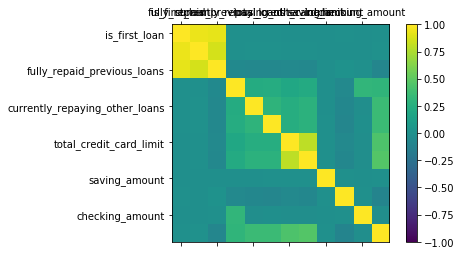

is_first_loan  fully_repaid_previous_loans  \
is_first_loan                        1.000000                     0.937598   
fully_repaid_previous_loans          0.937598                     1.000000   
currently_repaying_other_loans       0.928767                     0.867965   
total_credit_card_limit              0.000679                     0.005712   
saving_amount                        0.005650                     0.009899   
checking_amount                      0.005114                     0.009189   
is_employed                         -0.000971                     0.001688   
yearly_salary                       -0.001674                     0.001855   
age                                 -0.002353                    -0.001454   
dependent_number                     0.000887                    -0.000526   
avg_per_credit_card_limit__ly       -0.002585                    -0.000406   
moneymaking                          0.003219                     0.009094   

                                currently_repaying_other_loans  \
is_first_loan                                         0.928767   
fully_repaid_previous_loans                           0.867965   
currently_repaying_other_loans                        1.000000   
total_credit_card_limit                              -0.052500   
saving_amount                                        -0.063285   
checking_amount                                      -0.062500   
is_employed                                          -0.055670   
yearly_salary                                        -0.065930   
age                                                  -0.003097   
dependent_number                                      0.018802   
avg_per_credit_card_limit__ly                         0.000093   
moneymaking                                          -0.078265   

                                total_credit_card_limit  saving_amount  \
is_first_loan                                  0.000679       0.005650   
fully_repaid_previous_loans                    0.005712       0.009899   
currently_repaying_other_loans                -0.052500      -0.063285   
total_credit_card_limit                        1.000000       0.234181   
saving_amount                                  0.234181       1.000000   
checking_amount                                0.240926       0.301041   
is_employed                                    0.195274       0.248526   
yearly_salary                                  0.222497       0.288712   
age                                           -0.004052      -0.005321   
dependent_number                              -0.058650      -0.075647   
avg_per_credit_card_limit__ly                  0.318143      -0.010489   
moneymaking                                    0.311709       0.363347   

                                checking_amount  is_employed  yearly_salary  \
is_first_loan                          0.005114    -0.000971      -0.001674   
fully_repaid_previous_loans            0.009189     0.001688       0.001855   
currently_repaying_other_loans        -0.062500    -0.055670      -0.065930   
total_credit_card_limit                0.240926     0.195274       0.222497   
saving_amount                          0.301041     0.248526       0.288712   
checking_amount                        1.000000     0.244383       0.282909   
is_employed                            0.244383     1.000000       0.799051   
yearly_salary                          0.282909     0.799051       1.000000   
age                                    0.000355     0.005059       0.005412   
dependent_number                      -0.081963    -0.060847      -0.073218   
avg_per_credit_card_limit__ly         -0.006122    -0.009516      -0.011848   
moneymaking                            0.359714     0.440462       0.466898   

                                     age  dependent_number  \
is_first_loan                  -0.002353          0.000887   
fully_repaid_previous_loans    -0.001454   

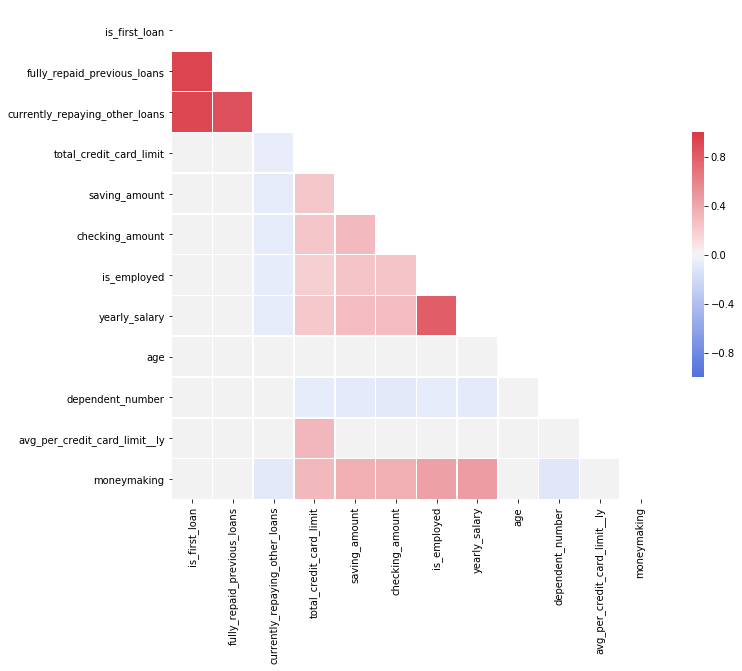

In [21]:
correlations = df_binary.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = list(df_model)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

# Using seaborn package
# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmin = -1, vmax= 1 , center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

correlations

Column name: currently_repaying_other_loans


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


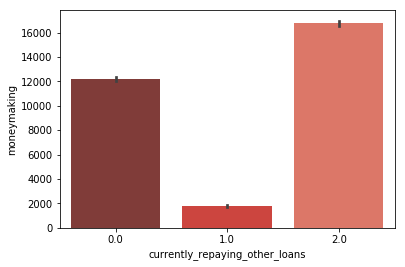

Column name: dependent_number


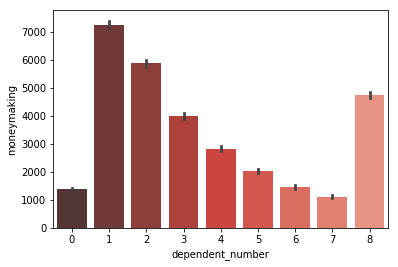

Column name: fully_repaid_previous_loans


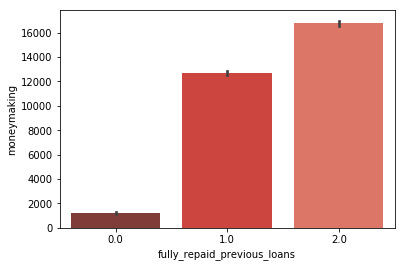

Column name: is_employed


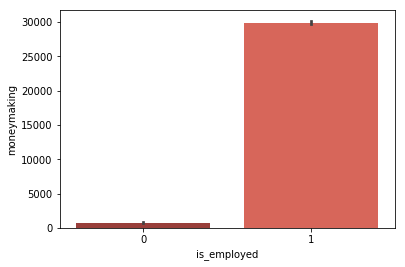

Column name: is_first_loan


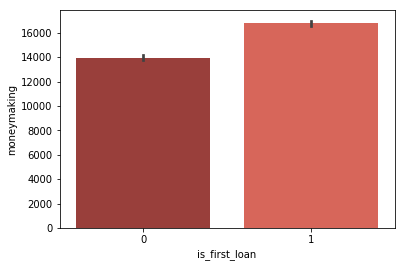

Column name: loan_purpose


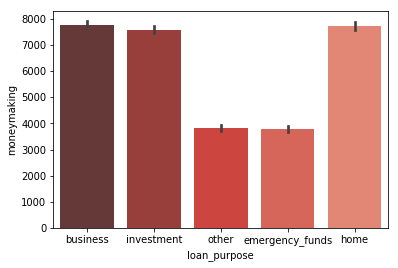

In [22]:
for col in df_binary_category:
  if col == 'moneymaking':
    continue
  else:
    print('Column name: %s' %col)
    sns.barplot(x=col, y='moneymaking', data=df_binary[[col,'moneymaking']]
              , palette="Reds_d", estimator = sum)
    plt.show()

Column name: total_credit_card_limit
> No.outliner: 338 



D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


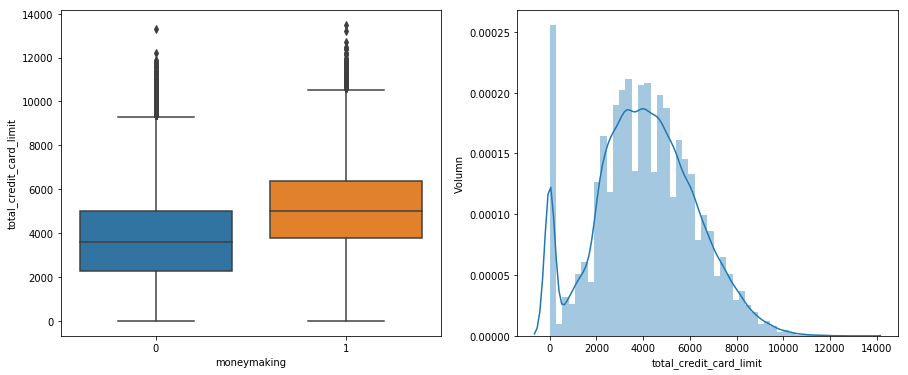

Column name: saving_amount
> No.outliner: 4275 



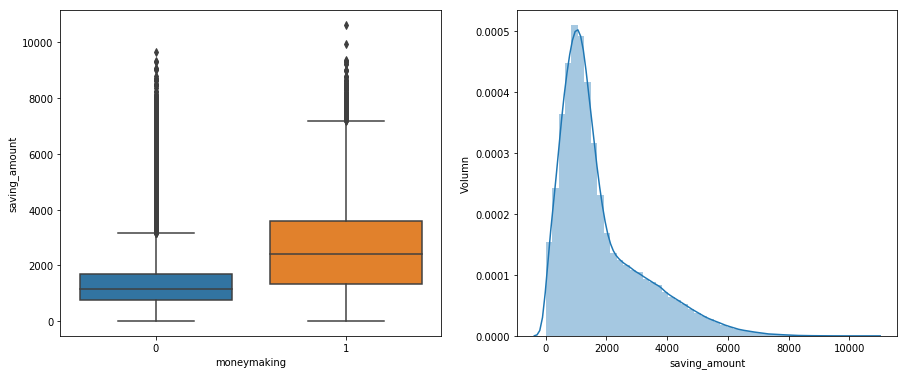

Column name: checking_amount
> No.outliner: 2217 



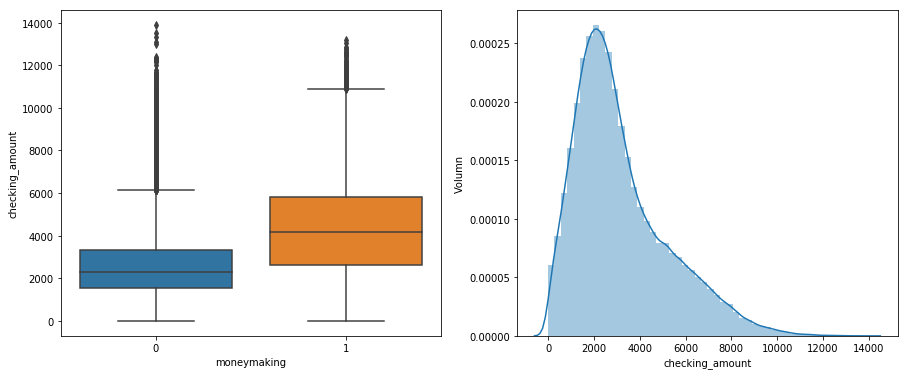

Column name: yearly_salary
> No.outliner: 3 



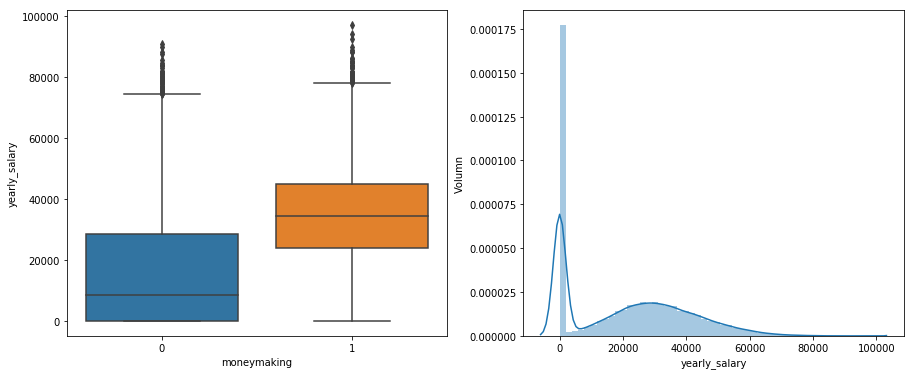

Column name: age
> No.outliner: 90 



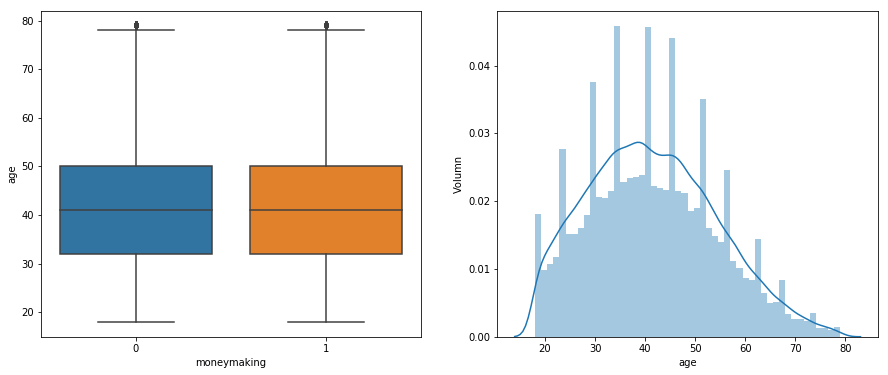

Column name: avg_per_credit_card_limit__ly
> No.outliner: 7036 



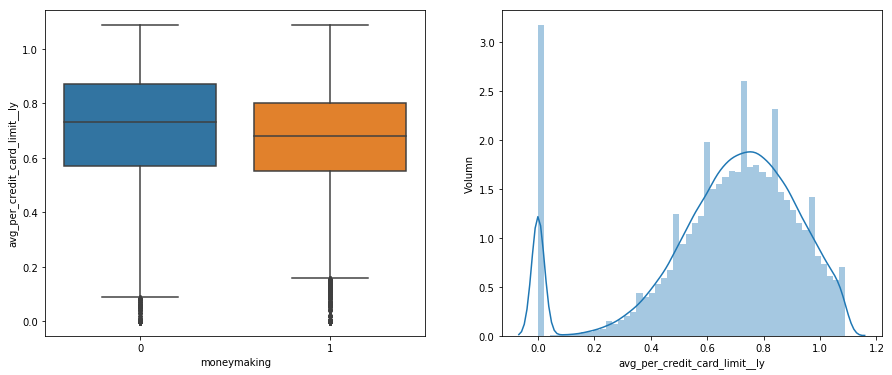

In [23]:
# Using boxplot to analyze the continous feature
for col in df_binary_continous:
  plt.figure(figsize=(15,6))
  plt.subplot(1, 2, 1)
  plot = sns.boxplot(x="moneymaking", y=col, whis=1.6, data=df_binary)
  # which defined as the proportion of the IQR past the low and high quartiles to extend the plot whiskers 
  # or interquartile range (IQR)
  # therefore, maximum = Q3 + 1.6*IQR , min = Q1 - 1.6*IQR
  Q1 = df_binary[col].quantile(0.25)
  Q3 = df_binary[col].quantile(0.75)
  IQR = Q3 - Q1
  print('Column name: %s' %col)
  print('> No.outliner: %d \n' %((df_binary[col] < (Q1 - 1.6 * IQR)) | (df_binary[col] > (Q3 + 1.6 * IQR))).sum())
  
  
  plt.subplot(1, 2, 2)
  fig = sns.distplot(df_binary[col].dropna())#.hist(bins=20)
  fig.set_ylabel('Volumn')
  fig.set_xlabel(col)
  plt.show()  

Column name: saving_amount
Check null: False
> No.outliner: 693 



D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


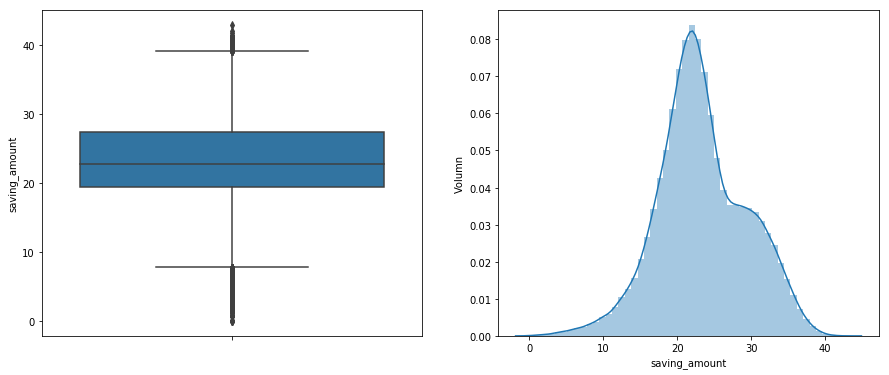

Column name: checking_amount
Check null: False
> No.outliner: 499 



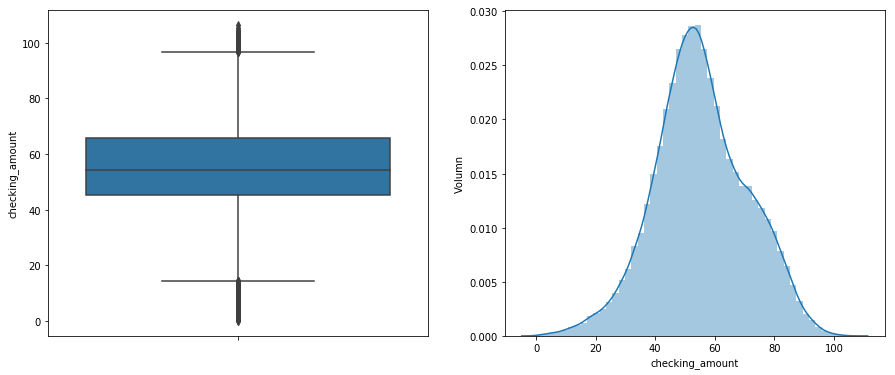

Column name: yearly_salary
Check null: False
> No.outliner: 0 



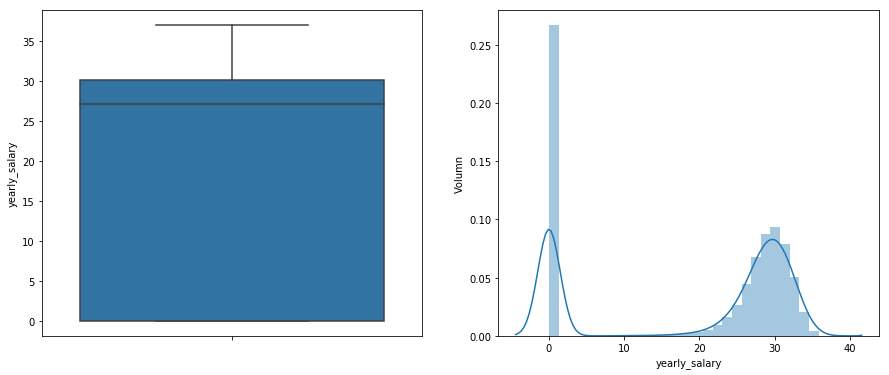

Column name: avg_per_credit_card_limit__ly
Check null: False
> No.outliner: 0 



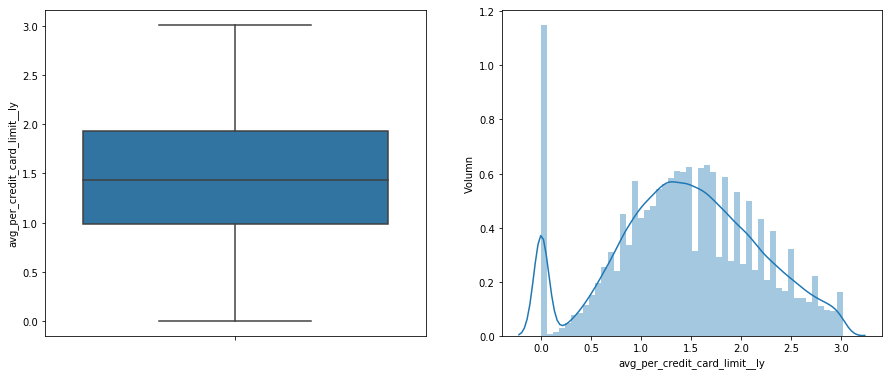

In [24]:
for col_name in df_binary_continous:
  if col_name == 'total_credit_card_limit' or col_name == 'age':    
    continue
  else:
    df_binary[col_name], para = stats.boxcox(df_binary[col_name]+1)
    col = df_binary[col_name]
    print('Column name: %s' %col_name)
    #print(np.isinf(col).sum()>1)
    print('Check null: %s'%(col.isnull().sum()>0))

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    print('> No.outliner: %d \n' %((col < (Q1 - 1.6 * IQR)) | (col > (Q3 + 1.6 * IQR))).sum())

    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=col)
    fig.set_title('')
    fig.set_ylabel(col_name)

    plt.subplot(1, 2, 2)
    fig = sns.distplot(col.dropna())#.hist(bins=20)
    fig.set_ylabel('Volumn')
    fig.set_xlabel(col_name)

    plt.show()

In [26]:
df_binary_category

Index(['currently_repaying_other_loans', 'dependent_number',
       'fully_repaid_previous_loans', 'is_employed', 'is_first_loan',
       'loan_purpose', 'moneymaking'],
      dtype='object')

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [28]:
y = df_binary['moneymaking']
X = df_binary.drop(['moneymaking'],axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Endcoding the categorical features and getting the dummies matrix
X_train=pd.get_dummies(X_train, prefix=['loan_purpose'], columns=['loan_purpose'])

In [30]:
# Build a forest and compute the feature importances
clf_forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
clf_forest.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Feature ranking:
1. yearly_salary (0.168182)
2. saving_amount (0.151347)
3. checking_amount (0.147347)
4. total_credit_card_limit (0.121064)
5. is_employed (0.109725)
6. avg_per_credit_card_limit__ly (0.109017)
7. age (0.079907)
8. dependent_number (0.054567)
9. currently_repaying_other_loans (0.020233)
10. fully_repaid_previous_loans (0.008316)
11. loan_purpose_emergency_funds (0.005938)
12. is_first_loan (0.005150)
13. loan_purpose_investment (0.005061)
14. loan_purpose_business (0.004933)
15. loan_purpose_home (0.004923)


Text(0.5,0,'Relative Importance')

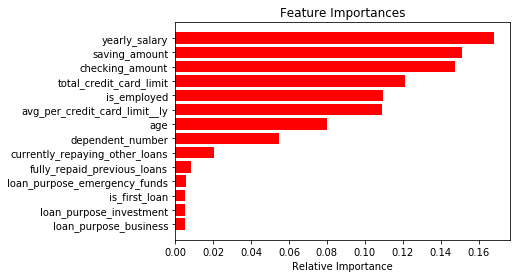

In [32]:
# std = np.std([tree.feature_importances_ for tree in clf_forest.estimators_],axis=0)
features = X_train.columns
importances = clf_forest.feature_importances_
nSelectedFeature = 15
indices = np.argsort(importances)[-(nSelectedFeature-1):]

# Print the feature ranking
rank = np.argsort(clf_forest.feature_importances_)[::-1]
print("Feature ranking:")
for f in range(nSelectedFeature):
    print("%d. %s (%f)" % (f + 1, features[rank[f]] , importances[rank[f]]))


# Bar plot
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

In [33]:
df_binary_trained = df_binary.drop(columns = ['is_first_loan','fully_repaid_previous_loans'])
df_binary_trained.sample(5)

currently_repaying_other_loans  total_credit_card_limit  saving_amount  \
43213                             1.0                     5000      28.799723   
68053                             0.0                     3500      25.297144   
54204                             1.0                     4600      24.239819   
35623                             2.0                        0      20.567460   
67684                             2.0                     6800      20.185606   

       checking_amount  is_employed  yearly_salary  age  dependent_number  \
43213        75.970670            1      34.258432   26                 2   
68053        40.048001            0       0.000000   40                 7   
54204        43.653133            0       0.000000   37                 6   
35623        68.625973            0       0.000000   46                 8   
67684        67.923427            1      33.003220   32                 1   

       avg_per_credit_card_limit__ly loan_purpose  moneymaking  
43213                       0.987804        other            0  
68053                       1.400959   investment            0  
54204                       1.305753        other            0  
35623                       0.000000   investment            0  
67684                       1.709653   investment            1

In [34]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """

    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x,
                                      weights=self.weights)),
                axis=1,
                arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [35]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [36]:
y = df_binary_trained['moneymaking']
X = df_binary_trained.drop(['moneymaking'],axis=1).copy()
X=pd.get_dummies(X, prefix=['loan_purpose'], columns=['loan_purpose'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=0)
# select 5 feature b/c 
clf3 = KNeighborsClassifier(n_neighbors=2, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.2f (+/- %0.5f) [%s]"% (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.00371) [Logistic regression]
ROC AUC: 0.88 (+/- 0.00449) [Decision tree]
ROC AUC: 0.80 (+/- 0.00428) [KNN]


In [38]:
# Majority Rule (hard) Voting
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.2f (+/- %0.2f) [%s]"% (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.00) [Logistic regression]
ROC AUC: 0.88 (+/- 0.00) [Decision tree]
ROC AUC: 0.80 (+/- 0.00) [KNN]
ROC AUC: 0.89 (+/- 0.00) [Majority voting]


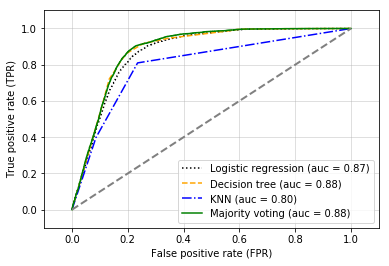

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
  # assuming the label of the positive class is 1
  y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)
  plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
#plt.savefig('images/04_04', dpi=300)
plt.show()

In [40]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',max_depth=None,random_state=1)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [41]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
tree_y_train_pred = tree.predict(X_train)
tree_y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, tree_y_train_pred)
tree_test = accuracy_score(y_test, tree_y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'% (tree_train, tree_test))
print('comparing bank profitability vs your my profitability in test_set %.3f/%.3f \n'%(y_test.sum(), tree_y_test_pred.sum()))

bag = bag.fit(X_train, y_train)
bag_y_train_pred = bag.predict(X_train)
bag_y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, tree_y_train_pred)
bag_test = accuracy_score(y_test, tree_y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'% (bag_train, bag_test))
print('comparing bank profitability vs your my profitability in test_set %.3f/%.3f'%(y_test.sum(), bag_y_test_pred.sum()))

Decision tree train/test accuracies 1.000/0.772
comparing bank profitability vs your my profitability in test_set 6149.000/6029.000 

Bagging train/test accuracies 1.000/0.772
comparing bank profitability vs your my profitability in test_set 6149.000/7384.000


In [42]:
# Use box plot with serveral continous variable
df_multiclass_continous = ['total_credit_card_limit','saving_amount','checking_amount','yearly_salary',
                       'age','avg_per_credit_card_limit__ly']
df_multiclass_category = df_multiclass.columns.difference(['total_credit_card_limit','saving_amount','checking_amount','yearly_salary',
                       'age','avg_per_credit_card_limit__ly'])

is_first_loan  fully_repaid_previous_loans  \
is_first_loan                        1.000000                     0.937598   
fully_repaid_previous_loans          0.937598                     1.000000   
currently_repaying_other_loans       0.928767                     0.867965   
total_credit_card_limit              0.000679                     0.005712   
saving_amount                        0.005650                     0.009899   
checking_amount                      0.005114                     0.009189   
is_employed                         -0.000971                     0.001688   
yearly_salary                       -0.001674                     0.001855   
age                                 -0.002353                    -0.001454   
dependent_number                     0.000887                    -0.000526   
avg_per_credit_card_limit__ly       -0.002585                    -0.000406   
profit                               0.007662                     0.013728   

                                currently_repaying_other_loans  \
is_first_loan                                         0.928767   
fully_repaid_previous_loans                           0.867965   
currently_repaying_other_loans                        1.000000   
total_credit_card_limit                              -0.052500   
saving_amount                                        -0.063285   
checking_amount                                      -0.062500   
is_employed                                          -0.055670   
yearly_salary                                        -0.065930   
age                                                  -0.003097   
dependent_number                                      0.018802   
avg_per_credit_card_limit__ly                         0.000093   
profit                                               -0.079540   

                                total_credit_card_limit  saving_amount  \
is_first_loan                                  0.000679       0.005650   
fully_repaid_previous_loans                    0.005712       0.009899   
currently_repaying_other_loans                -0.052500      -0.063285   
total_credit_card_limit                        1.000000       0.234181   
saving_amount                                  0.234181       1.000000   
checking_amount                                0.240926       0.301041   
is_employed                                    0.195274       0.248526   
yearly_salary                                  0.222497       0.288712   
age                                           -0.004052      -0.005321   
dependent_number                              -0.058650      -0.075647   
avg_per_credit_card_limit__ly                  0.318143      -0.010489   
profit                                         0.289462       0.385200   

                                checking_amount  is_employed  yearly_salary  \
is_first_loan                          0.005114    -0.000971      -0.001674   
fully_repaid_previous_loans            0.009189     0.001688       0.001855   
currently_repaying_other_loans        -0.062500    -0.055670      -0.065930   
total_credit_card_limit                0.240926     0.195274       0.222497   
saving_amount                          0.301041     0.248526       0.288712   
checking_amount                        1.000000     0.244383       0.282909   
is_employed                            0.244383     1.000000       0.799051   
yearly_salary                          0.282909     0.799051       1.000000   
age                                    0.000355     0.005059       0.005412   
dependent_number                      -0.081963    -0.060847      -0.073218   
avg_per_credit_card_limit__ly         -0.006122    -0.009516      -0.011848   
profit                                 0.381313     0.230978       0.333898   

                                     age  dependent_number  \
is_first_loan                  -0.002353          0.000887   
fully_repaid_previous_loans    -0.001454   

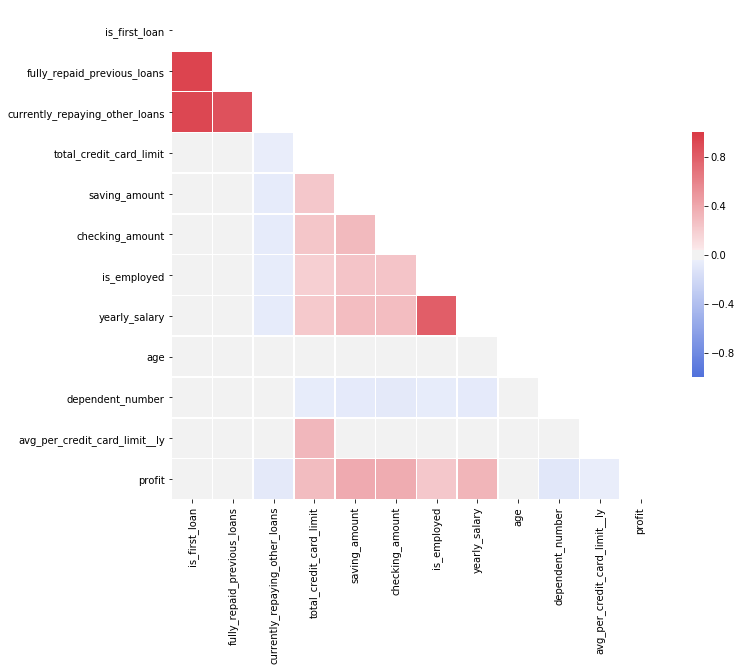

In [43]:
import matplotlib.pyplot as plt

correlations = df_multiclass.corr()
#fig = plt.figure()
#ax = fig.add_subplot(111)
#cax = ax.matshow(correlations, vmin=-1, vmax=1)
#fig.colorbar(cax)
#names = list(df_model)
#ax.set_xticklabels(names)
#ax.set_yticklabels(names)
#plt.show()

# Using seaborn package
# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmin = -1, vmax= 1 , center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

correlations

Column name: currently_repaying_other_loans


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


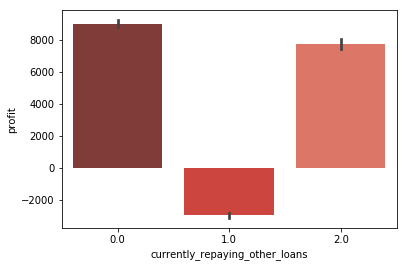

Column name: dependent_number


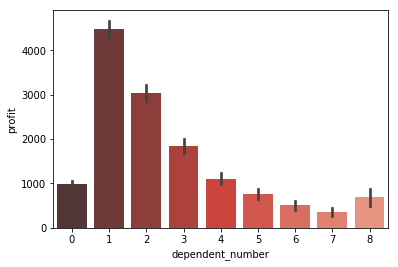

Column name: fully_repaid_previous_loans


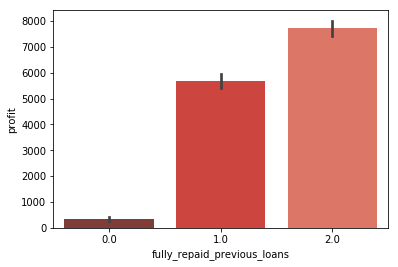

Column name: is_employed


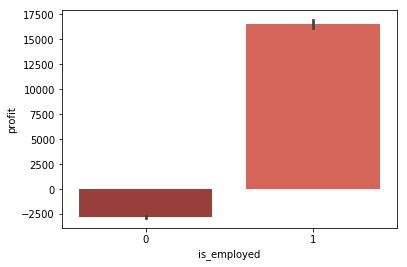

Column name: is_first_loan


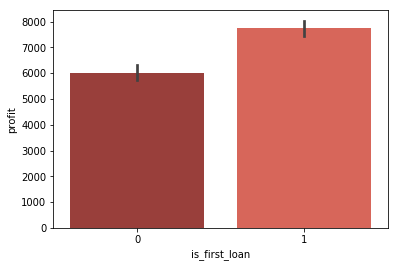

Column name: loan_purpose


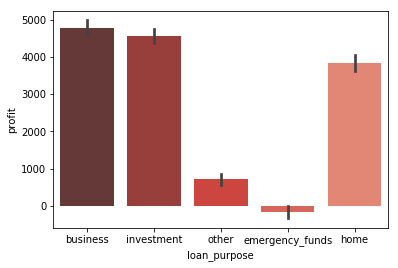

In [46]:
#sns.catplot(x='currently_repaying_other_loans', y='moneymaking',
#                hue='moneymaking',
#                data=df_binary[['currently_repaying_other_loans','moneymaking']]
#            , kind="bar",height=8, aspect=1.4 , estimator = len())

#!pip install seaborn==0.9.0
# Using barplot to analyze categorical features
for col in df_multiclass_category:
  if col == 'profit':
    continue
  else:
    print('Column name: %s' %col)
    sns.barplot(x=col, y='profit', data=df_multiclass[[col,'profit']]
              , palette="Reds_d", estimator = sum)
    plt.show()

Column name: total_credit_card_limit
> No.outliner: 338 



D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


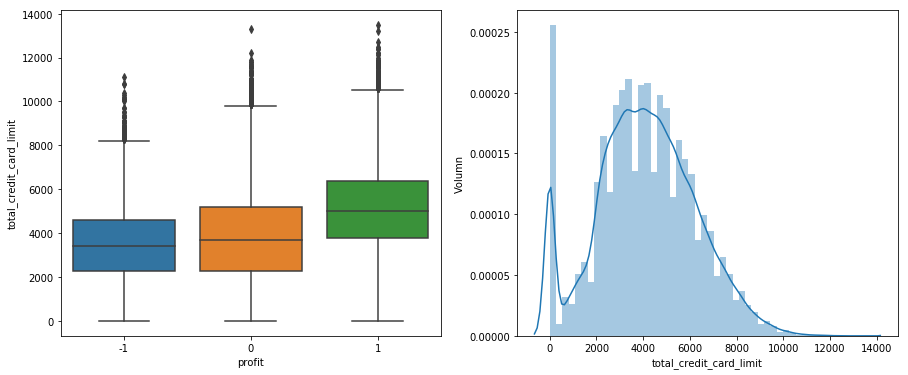

Column name: saving_amount
> No.outliner: 4275 



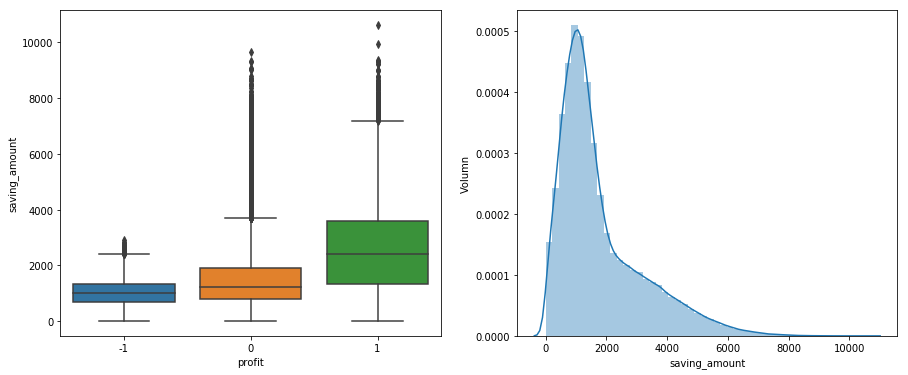

Column name: checking_amount
> No.outliner: 2217 



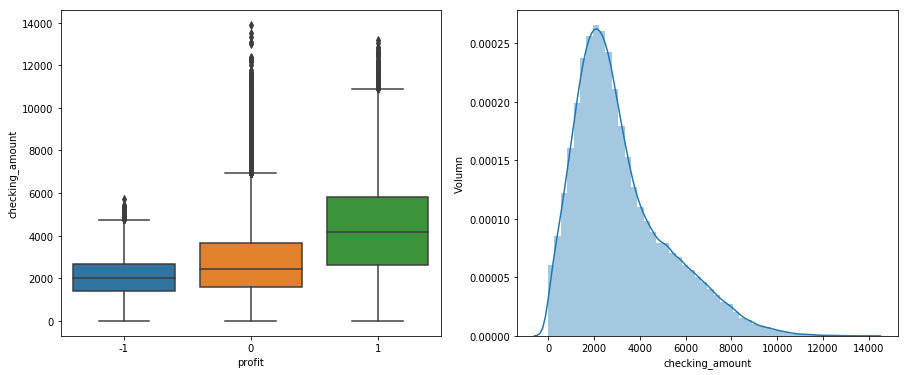

Column name: yearly_salary
> No.outliner: 3 



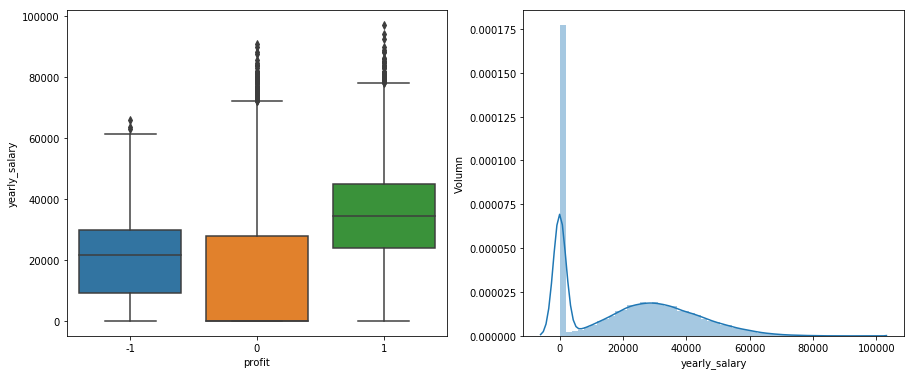

Column name: age
> No.outliner: 90 



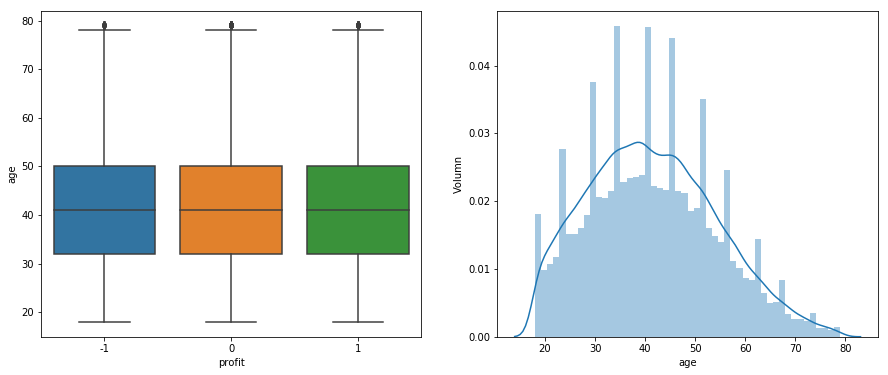

Column name: avg_per_credit_card_limit__ly
> No.outliner: 7036 



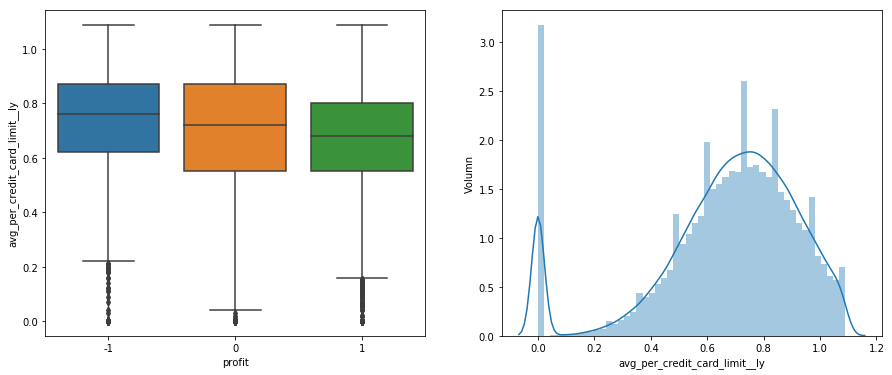

In [47]:
# Using boxplot to analyze the continous feature
for col in df_multiclass_continous:
  plt.figure(figsize=(15,6))
  plt.subplot(1, 2, 1)
  plot = sns.boxplot(x="profit", y=col, whis=1.6, data=df_multiclass)
  # which defined as the proportion of the IQR past the low and high quartiles to extend the plot whiskers 
  # or interquartile range (IQR)
  # therefore, maximum = Q3 + 1.6*IQR , min = Q1 - 1.6*IQR
  Q1 = df_multiclass[col].quantile(0.25)
  Q3 = df_multiclass[col].quantile(0.75)
  IQR = Q3 - Q1
  print('Column name: %s' %col)
  print('> No.outliner: %d \n' %((df_multiclass[col] < (Q1 - 1.6 * IQR)) | (df_multiclass[col] > (Q3 + 1.6 * IQR))).sum())
  
  
  plt.subplot(1, 2, 2)
  fig = sns.distplot(df_multiclass[col].dropna())#.hist(bins=20)
  fig.set_ylabel('Volumn')
  fig.set_xlabel(col)
  plt.show() 

Column name: saving_amount
Check null: False
> No.outliner: 693 



D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


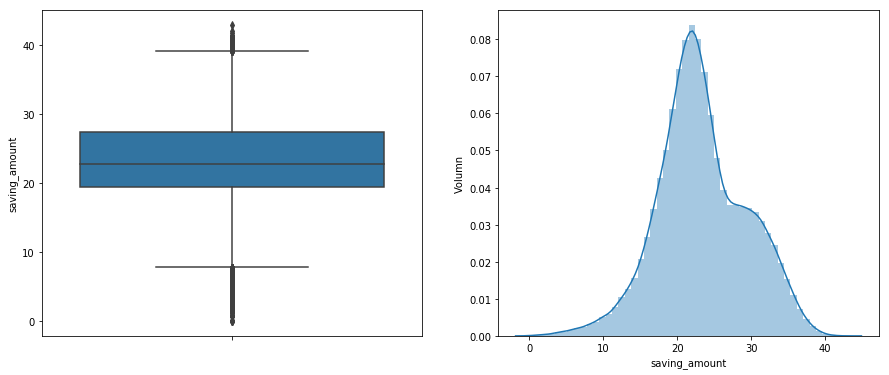

Column name: checking_amount
Check null: False
> No.outliner: 499 



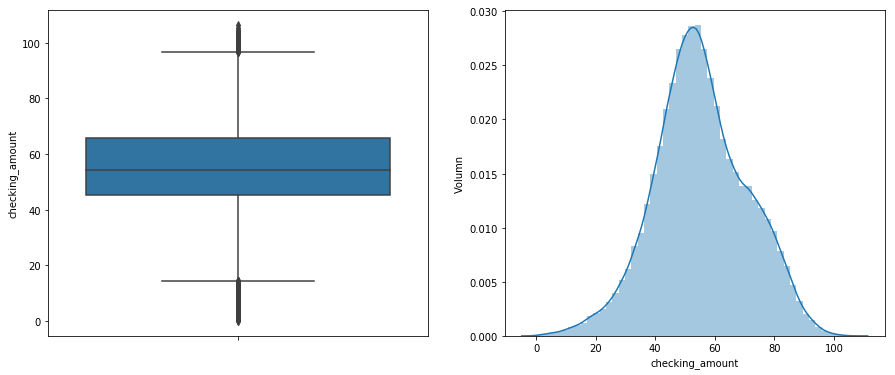

Column name: yearly_salary
Check null: False
> No.outliner: 0 



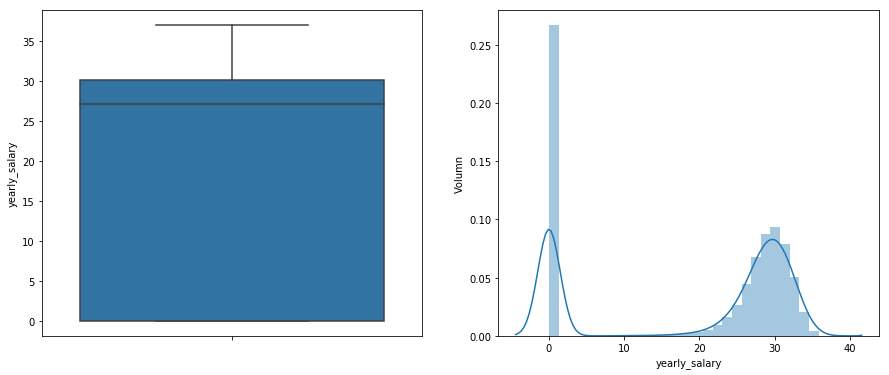

Column name: avg_per_credit_card_limit__ly
Check null: False
> No.outliner: 0 



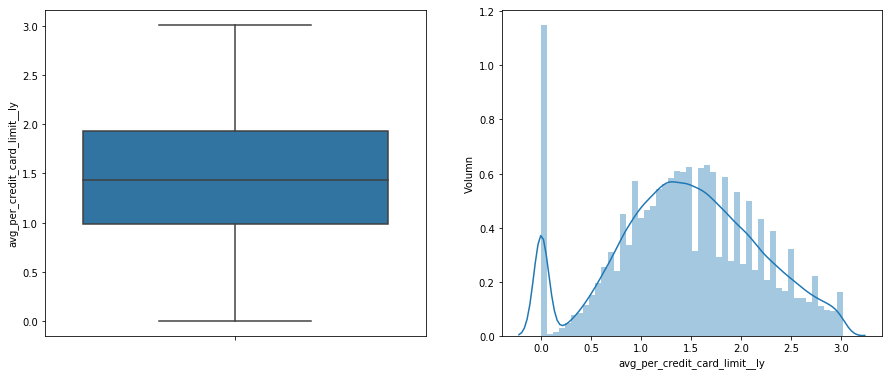

In [48]:
# plus 1 for eliminating non-positive case
for col_name in df_multiclass_continous:
  if col_name == 'total_credit_card_limit' or col_name == 'age':    
    continue
  else:
    df_multiclass[col_name], para = stats.boxcox(df_multiclass[col_name]+1)
    col = df_multiclass[col_name]
    print('Column name: %s' %col_name)
    #print(np.isinf(col).sum()>1)
    print('Check null: %s'%(col.isnull().sum()>0))

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    print('> No.outliner: %d \n' %((col < (Q1 - 1.6 * IQR)) | (col > (Q3 + 1.6 * IQR))).sum())

    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=col)
    fig.set_title('')
    fig.set_ylabel(col_name)

    plt.subplot(1, 2, 2)
    fig = sns.distplot(col.dropna())#.hist(bins=20)
    fig.set_ylabel('Volumn')
    fig.set_xlabel(col_name)

    plt.show()

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

In [50]:
y = df_multiclass['profit']
X = df_multiclass.drop(['profit'],axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Endcoding the categorical features and getting the dummies matrix
X_train=pd.get_dummies(X_train, prefix=['loan_purpose'], columns=['loan_purpose'])

In [52]:
# Build a forest and compute the feature importances
clf_forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
clf_forest.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Feature ranking:
1. yearly_salary (0.153983)
2. saving_amount (0.142181)
3. checking_amount (0.138966)
4. avg_per_credit_card_limit__ly (0.126531)
5. total_credit_card_limit (0.121106)
6. is_employed (0.105579)
7. age (0.095340)
8. dependent_number (0.061942)
9. currently_repaying_other_loans (0.015804)
10. fully_repaid_previous_loans (0.009227)
11. loan_purpose_home (0.005519)
12. loan_purpose_investment (0.005184)
13. loan_purpose_emergency_funds (0.004944)
14. loan_purpose_business (0.004803)
15. is_first_loan (0.004665)


Text(0.5,0,'Relative Importance')

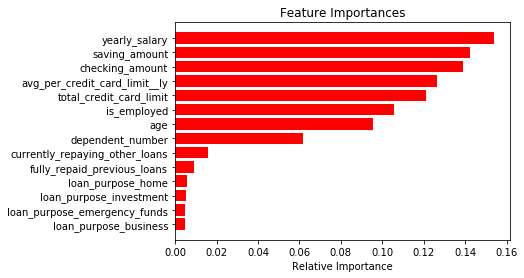

In [57]:
# std = np.std([tree.feature_importances_ for tree in clf_forest.estimators_],axis=0)
features = X_train.columns
importances = clf_forest.feature_importances_
nSelectedFeature = 15
indices = np.argsort(importances)[-(nSelectedFeature-1):]

# Print the feature ranking
rank = np.argsort(clf_forest.feature_importances_)[::-1]
print("Feature ranking:")
for f in range(nSelectedFeature):
    print("%d. %s (%f)" % (f + 1, features[rank[f]] , importances[rank[f]]))


# Bar plot
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

In [58]:
df_multiclass_trained = df_multiclass.drop(columns = ['is_first_loan','fully_repaid_previous_loans'])
df_multiclass_trained.sample(5)

currently_repaying_other_loans  total_credit_card_limit  saving_amount  \
68986                             2.0                     7800      26.538923   
55840                             2.0                     4200      20.921005   
98813                             0.0                     2300      26.573125   
49124                             2.0                     1600      23.319062   
42058                             0.0                     2800      17.480084   

       checking_amount  is_employed  yearly_salary  age  dependent_number  \
68986        81.651542            0       0.000000   33                 2   
55840        72.127570            1      30.949063   24                 2   
98813        73.486778            1      29.486242   52                 4   
49124        35.104335            0       0.000000   34                 8   
42058        49.255641            0       0.000000   40                 4   

       avg_per_credit_card_limit__ly loan_purpose  profit  
68986                       0.394144   investment       0  
55840                       1.274847     business       1  
98813                       1.568101     business       1  
49124                       1.533812         home      -1  
42058                       2.136513   investment       0

In [55]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC as svc
from scipy.stats import randint as sp_randint

In [76]:
y = df_multiclass_trained['profit']
X = df_multiclass_trained.drop(['profit'],axis=1).copy()

In [77]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [78]:
X=pd.get_dummies(X, prefix=['loan_purpose'], columns=['loan_purpose'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
param_dist = {}
mv_clf = MajorityVoteClassifier(
    classifiers=[GaussianNB(), 
                 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                   max_features=10, max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=5,
                   min_weight_fraction_leaf=0.0, presort=False, random_state=0,
                   splitter='best'), 
                 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                  metric_params=None, n_jobs=1, n_neighbors=12, p=2,
                  weights='distance')])
RDS_scores = RandomizedSearchCV(mv_clf, param_distributions=param_dist,
                                   n_iter = 1, cv=2).fit(X_train, y_train)
print(RDS_scores.cv_results_['mean_test_score'][RDS_scores.best_index_])
print(RDS_scores.cv_results_['std_test_score'][RDS_scores.best_index_])
print(RDS_scores.cv_results_['params'][RDS_scores.best_index_])
print('Best estimater: \n %s' %RDS_scores.best_estimator_)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

0.7164564787339268
0.001761039972811728
{}
Best estimater: 
 MajorityVoteClassifier(classifiers=[GaussianNB(priors=None), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_wei...wski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='distance')],
            vote='classlabel', weights=None)


In [80]:
RDS_scores.cv_results_

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are acces

{'mean_fit_time': array([0.19912672]),
 'std_fit_time': array([0.00068998]),
 'mean_score_time': array([0.96235967]),
 'std_score_time': array([0.00408602]),
 'params': [{}],
 'split0_test_score': array([0.71469548]),
 'split1_test_score': array([0.71821756]),
 'mean_test_score': array([0.71645648]),
 'std_test_score': array([0.00176104]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.77126042]),
 'split1_train_score': array([0.77008481]),
 'mean_train_score': array([0.77067262]),
 'std_train_score': array([0.0005878])}

In [81]:
RDS_scores.cv_results_

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are acces

{'mean_fit_time': array([0.19912672]),
 'std_fit_time': array([0.00068998]),
 'mean_score_time': array([0.96235967]),
 'std_score_time': array([0.00408602]),
 'params': [{}],
 'split0_test_score': array([0.71469548]),
 'split1_test_score': array([0.71821756]),
 'mean_test_score': array([0.71645648]),
 'std_test_score': array([0.00176104]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.77126042]),
 'split1_train_score': array([0.77008481]),
 'mean_train_score': array([0.77067262]),
 'std_train_score': array([0.0005878])}

In [82]:
from sklearn.linear_model import LogisticRegressionCV
clf1 = LogisticRegressionCV(cv = 5, penalty='l2', solver ='sag', random_state=1, multi_class = 'multinomial') #
clf1.fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=1, refit=True, scoring=None, solver='sag',
           tol=0.0001, verbose=0)

In [84]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',max_depth=None,random_state=1)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [85]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
tree_y_train_pred = tree.predict(X_train)
tree_y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, tree_y_train_pred)
tree_test = accuracy_score(y_test, tree_y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'% (tree_train, tree_test))
print('comparing bank profitability vs your my profitability in test_set %.3f/%.3f \n'%(y_test.sum(), tree_y_test_pred.sum()))

bag = bag.fit(X_train, y_train)
bag_y_train_pred = bag.predict(X_train)
bag_y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, tree_y_train_pred)
bag_test = accuracy_score(y_test, tree_y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'% (bag_train, bag_test))
print('comparing bank profitability vs your my profitability in test_set %.3f/%.3f'%(y_test.sum(), bag_y_test_pred.sum()))

Decision tree train/test accuracies 1.000/0.623
comparing bank profitability vs your my profitability in test_set 22992.000/22666.000 

Bagging train/test accuracies 1.000/0.623
comparing bank profitability vs your my profitability in test_set 22992.000/24425.000


In [86]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)

tree = tree.fit(X_train, y_train)
tree_y_train_pred = tree.predict(X_train)
tree_y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, tree_y_train_pred)
tree_test = accuracy_score(y_test, tree_y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'% (tree_train, tree_test))
print('comparing bank profitability vs your my profitability in test_set %.3f/%.3f \n'%(y_test.sum(), tree_y_test_pred.sum()))

ada = ada.fit(X_train, y_train)
ada_y_train_pred = ada.predict(X_train)
ada_y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, tree_y_train_pred)
ada_test = accuracy_score(y_test, tree_y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'% (ada_train, ada_test))
print('comparing bank profitability vs your my profitability in test_set %.3f/%.3f'%(y_test.sum(), ada_y_test_pred.sum()))

Decision tree train/test accuracies 1.000/0.623
comparing bank profitability vs your my profitability in test_set 22992.000/22666.000 

AdaBoost train/test accuracies 1.000/0.623
comparing bank profitability vs your my profitability in test_set 22992.000/22674.000


## Final Answer

1. As concerned in Feature Engineering section, I have built the variable to describe the model follows strategies 3 class-output: -1 lost, 0 neutral, 1 earned. However, the technique to solve this multiclass classification is over my level at this time. Therefore, I had changed to the binary problems as 0 non-profit and 1 profitable.


2. Using revenue-level rules above, however by my assumption, we agree that my model return 0-point when customers did not reload the rent amount and, we earn 1 point for in the others case. Following the result above, I have 3 times where the profit of my model is less than the banking model, however,  I also have a positive result for Bagging model, and in this case my model give a better result for customer credit rating model 6149.000/7365.000. It is worthy with more than 10 mins running time for fitting maximum depth-level of decision tree.


3. Based on Important features section, I have the feature ranking as follows Feature ranking:  <br>
  1. yearly_salary (0.168182)
  2. saving_amount (0.151347)
  3. checking_amount (0.147347)
  4. total_credit_card_limit (0.121064)
  5. is_employed (0.109725)

>Hence, the most critical feature is 'yearly_salary', and "is_employed" took at 5th position, and this feature is significantly relevent with "yearly_salary" but it is less important than. Concerning to meaning of data, "is_employed" shows that the persons are an employee and they have yearly revenue, however 'yearly_salary' tends to more relevant with the percentage of borrowing money, e.g the higher yearly salary they get, the more they interact with the bank.

4. It is really hard to find the effective answer for the question of adding other varibales, in my opinion, we should extend more about the customer information such as: living address, academic level or their vehicle type.